# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [35]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm


In [36]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 20:44:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  19.8MB/s    in 11s     

2021-10-26 20:44:51 (17.7 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [37]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [38]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

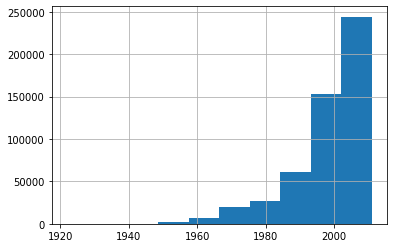

In [39]:
df[0].hist()

In [40]:
print(int(df[0].mean()), int(round(df[0].std())))

1998 11


In [41]:
from scipy.stats import mode
mode(y_train)

# нынче в моде 2007ой, эмо панк и блейзер

ModeResult(mode=array([2007]), count=array([35375]))

In [42]:
target_scaler_mean_year = np.mean(y_train)
# quantile_deviation = np.quantile(y_train, 0.75) - np.quantile(y_train, 0.5)
target_deviation = np.std(y_train)
# max_year = np.max(y_train)

def target_scaler(y):
  return  (y - target_scaler_mean_year) / target_deviation

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [43]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

clf = Ridge()
clf.fit(X_train, y_train)
y_pred_ridge = clf.predict(X_test)
print(mean_squared_error(y_test, y_pred_ridge, squared=False))
# В общем, при любых обстоятельствах (альфах) результат 9.510160711373395

9.510160711373395


In [44]:
constant_var = np.unique(y_train)
best_error = 10**10
best_year = 0

for constant in constant_var:
  error = mean_squared_error(y_test, np.full(len(y_test),constant), squared=False)
  if best_error > error:
    best_error = error
    best_year = constant

print(f'Best constant year is {best_year} with RMSE {best_error}')

Best constant year is 1998 with RMSE 10.863228020678134


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [45]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [46]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [47]:
# with the help of https://mlwhiz.com/blog/2020/09/09/pytorch_guide/
class SoundDataset(torch.utils.data.Dataset):

  def __init__(self, data, labels): 
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    return self.data[index], self.labels[index]

In [48]:
# Now let's normalize the target 

y_train_scaled = target_scaler(y_train)
y_test_scaled = target_scaler(y_test)

# Хочу обучить scaler, чтобы использовать его уже на тесте
scaler_for_model = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler_for_model.transform(X_train)
X_test_scaled = scaler_for_model.transform(X_test)

In [49]:
set_random_seed(123)

batch_size = 32

train_set = SoundDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(y_train_scaled).float()) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = SoundDataset(torch.from_numpy(X_test_scaled).float(), torch.from_numpy(y_test_scaled)) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = False) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model = nn.Sequential(
    nn.Linear(90, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.15),

    nn.Linear(128, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(0.15),
    
    nn.Linear(16, 1),
    # nn.LeakyReLU(),
    # nn.Dropout(0.1)
)


model.to(device)

# by https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
optimizer = torch.optim.Adam(model.parameters(), 
                   lr=0.0001, 
                   betas=(0.9, 0.999))

criterion = nn.MSELoss().float() # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

NUM_EPOCH = 4

In [50]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        scaler_for_model - sklearn.preprocessing.MinMaxScaler
                       necessary if you validate on test
    '''
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    model.train()

    mean_val_loss = []
    train_loss = []
    for epoch in range(NUM_EPOCH):
      for x_train, y_train in tqdm(train_loader):

        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = np.squeeze(model(x_train))
        loss = torch.sqrt(criterion(y_pred.float(), y_train.float()))
        train_loss.append(loss * target_deviation)
        loss.backward()
        optimizer.step()

      val_loss = []
      y_pred = []
      y_true = []
      with torch.no_grad():
        model.eval()
        for x_val, y_val in tqdm(test_loader):
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          y_pred.append(np.squeeze(model(x_val)))
          y_true.append(y_val)


        loss = torch.sqrt(criterion(target_deviation * torch.cat(y_pred), target_deviation * torch.cat(y_true)))
        val_loss.append(loss)
        print(f'Epoch: {epoch}, RMSE: {loss}')
    
    plt.plot(mean_val_loss[1:])
    plt.ylabel('RMSE')
    plt.xlabel('epoch number')
    plt.show()

    plt.plot(train_loss)
    plt.ylabel('RMSE')
    plt.xlabel('Train')
    plt.show()
    


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
        
        scaler_for_model - scaler for the whole test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    with torch.no_grad():
      model.eval()

      predicts = []
      count = 0
      loss = []

      for x_test, _ in tqdm(test_loader):
        x_test = x_test.to(device)
        y_pred = model(x_test)
        y_pred = y_pred.clone().detach()
        predicts.append(y_pred)
      
      predicts = torch.cat(predicts)
      return predicts

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, RMSE: 9.010177950388263


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, RMSE: 8.878092978485606


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, RMSE: 8.83955565465695


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, RMSE: 8.810605978885555


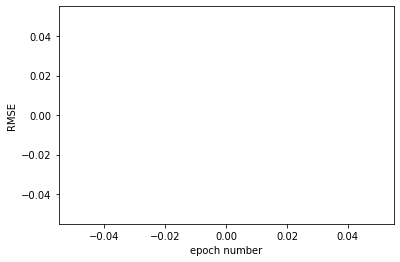

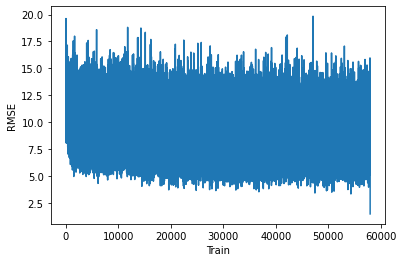

In [51]:
set_random_seed(123)
train(model, optimizer, criterion, train_loader, test_loader)

In [52]:
y_test_pred = test(model, criterion, test_loader)

  0%|          | 0/404 [00:00<?, ?it/s]

In [53]:
np.sqrt(mean_squared_error(np.around(np.array(y_test_pred.to('cpu')) * target_deviation + target_scaler_mean_year), y_test))

8.816885970133834

In [54]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

#Архитектура
Решил сразу начать с трех слоев, так как больше было бы слишком. Неочевидно было число нейронов. Я пробовал архитектуры 90-256-128-1, 90-64-32-1 и 90-128-64-1, но путем проб и ошибок (больших ошибок) я остановился на 90-128-16-1, так как результаты данной архитектуры мне показались более салансированными, да и просто лучше. Дальше именно эта архитектура использовалась во всех экспериментах.

#SGD vs Adam vs Adamw
В самом начале стоял выбор мезду оптимизаторами. Сперва показалось, что SGD вполне себе хорошо  справляется, но потом пришло осознание, что Adam он и есть Adam, правда из-за моей кривости я сперва работал с Adamw. Наболаввшись вдоволь спараметрами я принял решение, что weight_decay мне врял ли поможет (я пробовал брать от 0.1 до 0.001), RMSE показывал 12

#Нормализация 
Нормализация признаков не была чем-то примечательной. Я подумал, что в датасете могут быть выбросы и пробовал RobustScaler() вместе со StandardScaler(), но преимущества это не дало, так что икс я нормировал простым MinMaxScaler().
Интересней обстоит дело с таргетом. Я решил попробовать обучную нормализацию через вычетание среднего и деление на дисперсию, но это давало rmse в районе 9-10, не слишком лучше показала себя и другая задумка -- вычетание моды и деление на разброс в виде разности квантилей 75% и 25%, так что пришлось остановиться на обчном делении на наибольший год.


Валидация

В принципе дх прошло нормально, покрутили параметры примерно как на видео ниже\
https://t.me/failcascade/766